# Damped Rabi Flopping

This example covers damped Rabi flopping as calculated with the optical Bloch equations.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp

### Define the problem

As always, we must define the laser beams, magnetic field, and Hamiltonian.  Here, we will make a two-state system that is magnetic field insensitive and connected only by $\pi$ light.  In this particular case, we show how we can define the rotating frame such that the excited state of the Hamiltonian can rotate and the laser beams can rotate, or some combination of the two.  The total detuning is the sum of `ham_det` and `laser_det`.

In [3]:
ham_det = -2.
laser_det = -2.

laserBeams = pylcp.laserBeams(
    [{'kvec':np.array([1., 0., 0.]), 'pol':np.array([0., 0., 1.]),
      'pol_coord':'cartesian', 'delta':laser_det, 's':20.}]
)

magField = lambda R: np.zeros(R.shape)

# Now define the extremely simple Hamiltonian:
Hg = np.array([[0.]])
mugq = np.array([[[0.]], [[0.]], [[0.]]])
He = np.array([[-ham_det]])
mueq = np.array([[[0.]], [[0.]], [[0.]]])
dijq = np.array([[[0.]], [[1.]], [[0.]]])

gamma = 1

hamiltonian = pylcp.hamiltonian(Hg, He, mugq, mugq, dijq, gamma=gamma)
hamiltonian.print_structure()

[[((<g|H_0|g> 1x1), (<g|mu_q|g> 1x1)) (<g|d_q|e> 1x1)]
 [(<e|d_q|g> 1x1) ((<e|H_0|e> 1x1), (<e|mu_q|e> 1x1))]]


### Create the governing equation

In this example, we create both the rate equations and optical Bloch equations to compare.  We also print out the decay rates given the chosen $\Gamma$ to ensure the decay matrix evolution is being constructed properly for a two-level system.

In [4]:
# First the OBE:
obe = pylcp.obe(laserBeams, magField, hamiltonian,
                     transform_into_re_im=False)
rateeq = pylcp.rateeq(laserBeams, magField, hamiltonian)
print(obe.ev_mat['decay'])

[[ 0. +0.j  0. +0.j  0. +0.j  1. +0.j]
 [ 0. +0.j -0.5+0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j -0.5+0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -1. +0.j]]


### Evolve the state

We are going to evolve for $T=4\pi/\Gamma$, to see multiple oscillations.

In [5]:
t_eval = np.linspace(0, 4*np.pi/gamma, 501)
rho0 = np.zeros((hamiltonian.n**2,), dtype='complex128')
rho0[0] = 1.
obe.set_initial_rho(rho0)
obe.evolve_density([t_eval[0], t_eval[-1]], t_eval=t_eval)

N0 = np.zeros((rateeq.hamiltonian.n,))
N0[0] = 1
rateeq.set_initial_pop(N0)
rateeq.evolve_populations([t_eval[0], t_eval[-1]], t_eval=t_eval)

Plot it all up:

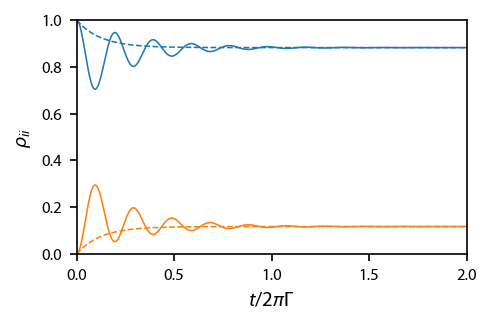

In [6]:
def final_value(s, det):
    return s/2/(1+s+4*det**2)

fig, ax = plt.subplots(1, 1, num='evolution', figsize=(3.25, 2.))
ax.plot(obe.sol.t*gamma/2/np.pi, np.abs(obe.sol.rho[0, 0, :]), linewidth=0.75,
         label='$\\rho_{00}$')
ax.plot(obe.sol.t*gamma/2/np.pi, np.abs(obe.sol.rho[1, 1, :]), linewidth=0.75,
         label='$\\rho_{11}$')
ax.plot(rateeq.sol.t*gamma/2/np.pi, np.abs(rateeq.sol.y[0, :]), linewidth=0.75,
         label='$\\rho_{00}$ (rate eq.)', color='C0', linestyle='--')
ax.plot(rateeq.sol.t*gamma/2/np.pi, np.abs(rateeq.sol.y[-1, :]), linewidth=0.75,
         label='$\\rho_{11}$ (rate eq.)', color='C1', linestyle='--')
# ax.plot(obe.sol.t[-1]*gamma/2/np.pi,
#          final_value(len(laserBeams)*laserBeams[0].beta(np.array([0., 0., 0.])),
#                      ham_det+laser_det) ,'o')
# ax.legend(fontsize=6)
ax.set_xlabel('$t/2\pi\Gamma$')
ax.set_ylabel('$\\rho_{ii}$')
ax.set_xlim((0., 2))
ax.set_ylim((0., 1))
fig.subplots_adjust(bottom=0.2)